In [1]:
#import stuffs
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

Rules:
- 8 person submit we continue

## 1. ETL

In [2]:
df = pd.read_csv("../data/income.csv")

In [3]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [4]:
#Check class label
df['label'].value_counts(normalize=True)

# Deep leaning should be able to handle this.
# Use imblear library

0    0.723333
1    0.276667
Name: label, dtype: float64

## 2. Categorify


In [5]:
cat_cols  = ['sex', 'education-num', 'marital-status',
       'workclass', 'occupation']

cont_cols = ['age', 'hours-per-week'] 
y         = ['label']

In [6]:
#Under the hood it becomes intigers, but you don't loose strings
for col in cat_cols:
    df[col] = df[col].astype('category')

## 3. Creating embedding size

In [7]:
cat_size = [len(df[col].cat.categories) for col in cat_cols]
cat_size

[2, 14, 6, 5, 12]

In [8]:
emb_size = [(size, min(50, size//2)) for size in cat_size]
emb_size

[(2, 1), (14, 7), (6, 3), (5, 2), (12, 6)]

In [9]:
#(12,6)
df['occupation'].unique()

#Each occupation is represented bu vector of 6 values

['Craft-repair', 'Exec-managerial', 'Prof-specialty', 'Farming-fishing', 'Handlers-cleaners', ..., 'Other-service', 'Sales', 'Tech-support', 'Protective-serv', 'Transport-moving']
Length: 12
Categories (12, object): ['Adm-clerical', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', ..., 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']

## 4. Combine all cat. cols into one tensor

In [10]:
#Convert to cat. features to tensor
#torch.int32
# sex   = df['sex'].cat.codes.values
# education_num = df['education-num'].cat.codes.values
# marita_status  = df['marital-status'].cat.codes.values
# workclass  = df['workclass'].cat.codes.values
# occupation  = df['occupation'].cat.codes.values

# cat_features = np.stack([sex, education_num, marita_status, workclass, occupation], 1)
# cat_features.shape

# cat_features = torch.tensor(cat_features, dtype=torch.int32)

In [11]:
# age  = df['age'].values 
# hr_per_week  = df['hours-per-week'].values

# conts = np.stack([age, hr_per_week], 1)

# conts = torch.tensor(conts, dtype=torch.float32)

In [12]:
#cat_features[:3]

In [13]:
#conts[:4]

In [14]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

cats = torch.tensor(cats, dtype=torch.int32)
cats[:5]


tensor([[ 1,  6,  3,  2,  1],
        [ 1, 11,  1,  1,  2],
        [ 1,  6,  0,  3,  7],
        [ 0, 12,  3,  0,  7],
        [ 0,  4,  5,  2,  3]], dtype=torch.int32)

## 5. Combine all continuous cols. into one tensor

In [15]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float32)


## 6. Y into tensor

In [16]:
y = torch.tensor(df[y].values).flatten()
y.shape

torch.Size([30000])

## 7 Create your training and test set

In [17]:
#train test split
train_size = 6000
test_size  = 1000

cat_train = cats[:train_size]
cat_test  = cats[train_size:test_size+train_size]
con_train = conts[:train_size]
con_test  = conts[train_size:test_size+train_size]
y_train   = y[:train_size]
y_test    = y[train_size:test_size+train_size]

## 8. Create the model


In [18]:
#class IncomeModel(nn.Module):


In [19]:
class IncomeModel(nn.Module):
    
    def __init__(self, emb_size, cont_size, out_size, layer_size = [200, 100], p=0.5):
        super().__init__()
        self.embed_layer = nn.ModuleList([nn.Embedding(unique, emb_s) for unique, emb_s in emb_size])
        self.dropout     = nn.Dropout(p)
        self.batchnorm1d = nn.BatchNorm1d(cont_size)
        
        #calculate input_size
        cat_size = sum(emb_s for _, emb_s in emb_size)
        input_size = cat_size + cont_size

        layerlist = []
        for i in layer_size:
            layerlist.append(nn.Linear(input_size, i))  #(input_size, 200)
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            input_size = i
        layerlist.append(nn.Linear(layer_size[-1], out_size))
        
        self.layers = nn.Sequential(*layerlist)
            
    def forward(self, x_cat, x_cont):
        # Get the embeddings for cat_cols
        # Then concatenate cat_cols into 1
        #x_cat.shape (sample_size, 5)
        #x_cont.shape(sample_size, 2)
        embeddings = []
        for i, e in enumerate(self.embed_layer):
            embeddings.append(e(x_cat[:, i]))
        #embedding.shape((sample_size, 1),(sample_size, 7),(sample_size, 3),(sample_size, 2),(sample_size, 6))
        #[(2, 1), (14, 7), (6, 3), (5, 2), (12, 6)]
        #embedding.shape((sample_size, 19)) - After concatenation
        x = torch.cat(embeddings, 1)  
        #embedding.shape
        
        # Perform the dropout fro these embeddings. Why?
        x = self.dropout(x)

        # Why do we not apply dropout for continuous columns
        
        # Batchnorm the con_cols
        x_cont = self.batchnorm1d(x_cont)
        
        # Conctenate cat and con
        #last x.shape (sample_size, 21)
        x = torch.cat([x, x_cont], 1)
       
        # Apply all the layers
        x = self.layers(x)
        
        return x

## 9. Test your model

In [20]:
#create model
model = IncomeModel(emb_size, conts.shape[1], len(y.unique()))

#try take some sample cat and cont
# cat[:1]
# conts[:1]

#run the model
output = model(cats[:5],conts[:5])

#check the output 
print(output.shape)

#is the output shape the thing you wan???
output
#what does this output means
#When is the output get normalized
    # I J_fn when we use CrossEntropy it applies softmax



torch.Size([5, 2])


tensor([[-0.5481,  0.0410],
        [-0.2287,  0.4595],
        [ 1.0841, -1.3270],
        [-0.5655,  0.0447],
        [ 0.9476,  1.7144]], grad_fn=<AddmmBackward0>)

## 10. Training !!

In [21]:
#cat_train

In [22]:
# Define loss function 
J_fn = nn.CrossEntropyLoss()
# Define optimizer (you can try use Adam)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

epochs = 500

losses = []

#for epoch
for i in range(epochs):
    #x_cat, x_cont
    #1. prediction using model()
    yhat = model(cat_train, con_train)
    #2. loss using J_fn()
    loss = J_fn(yhat, y_train)

    #please collect the loss and accuracy
    losses.append(loss)
    
    #3. empty the gradients (zero_grad())
    optimizer.zero_grad()
    #4. backpropagate (backward())
    loss.backward()
    #5. update parameters (step())
    optimizer.step()
    
    #every 50 epochs, print loss and accuracy
    if i % 50 == 1:
        print(f"Epoch: {i}; Loss: {loss:.2f}")    
    

Epoch: 1; Loss: 0.71
Epoch: 51; Loss: 0.30
Epoch: 101; Loss: 0.28
Epoch: 151; Loss: 0.27
Epoch: 201; Loss: 0.26
Epoch: 251; Loss: 0.26
Epoch: 301; Loss: 0.25
Epoch: 351; Loss: 0.25
Epoch: 401; Loss: 0.25
Epoch: 451; Loss: 0.24


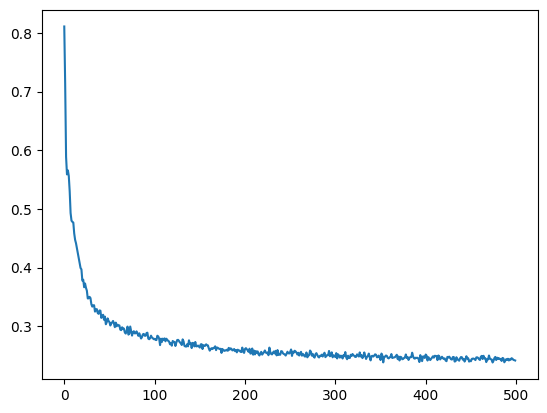

In [23]:
train_loss = [loss.item() for loss in losses]
plt.plot(range(epochs), train_loss)


## 11. Testing

In [24]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    yhat = model(cat_test, con_test)
    loss = J_fn(yhat, y_test)
    predicted = torch.max(yhat, 1)[1]
    acc  = accuracy_score(predicted, y_test)
    
print(acc)

0.874
